In [2]:
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from sklearn.base import BaseEstimator, TransformerMixin

class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}

    def fit(self, X, y=None):
        for column in X.columns:
            le = LabelEncoder()
            le.fit(X[column])
            self.label_encoders[column] = le
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column, le in self.label_encoders.items():
            X_transformed[column] = le.transform(X[column])
        return X_transformed

def create_preprocessing_pipeline(continuous_features, categorical_features, n_bins=10):
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    le_transformer = Pipeline([
        ('label_encoder', LabelEncoderTransformer())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('kbd', kbd, continuous_features),
            ('le', le_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    return preprocessor

def grid_search_with_cv(X, y):
    param_grid = {
        'max_depth': [10, 20, 30],
        'n_estimators': [10, 30, 50]
    }

    best_params = None
    best_mse = float('inf')
    results = []

    kf = KFold(n_splits=5)

    for max_depth in param_grid['max_depth']:
        for n_estimators in param_grid['n_estimators']:
            model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
            mse_scores = []

            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                mse_scores.append(mean_squared_error(y_val, y_pred))

            avg_mse = np.mean(mse_scores)
            results.append((max_depth, n_estimators, avg_mse))
            print(f"Params: max_depth={max_depth}, n_estimators={n_estimators} - MSE: {avg_mse}")

            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = (max_depth, n_estimators)

    print(f"Best Params: max_depth={best_params[0]}, n_estimators={best_params[1]} - MSE: {best_mse}")
    return best_params, results

def visualize_grid_search(results):
    max_depths = [r[0] for r in results]
    n_estimators = [r[1] for r in results]
    mses = [r[2] for r in results]

    fig = go.Figure(data=[go.Scatter3d(
        x=max_depths, y=n_estimators, z=mses,
        mode='markers',
        marker=dict(
            size=5,
            color=mses,
            colorscale='Viridis',
            colorbar=dict(title='MSE'),
            opacity=0.8
        )
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='Max Depth',
            yaxis_title='Number of Trees',
            zaxis_title='MSE'
        ),
        title='Grid Search Results'
    )

    fig.show()

if __name__ == '__main__':
    # Load the data
    df = pd.read_csv('train_data2.csv', index_col=0)
    continuous_features = ['macro_state_1', 'macro_state_2']
    categorical_features = ['category1', 'category2']

    preprocessor = create_preprocessing_pipeline(continuous_features, categorical_features, n_bins=10)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=30, max_depth=10, n_jobs=-1))
    ])

    X = df.drop(columns=['outcome'])
    y = df['outcome']

    # Perform grid search with cross-validation
    best_params, results = grid_search_with_cv(X.values, y.values)
    visualize_grid_search(results)

    # Fit the pipeline on the full dataset
    pipeline.fit(X, y)

    # Save the pipeline to disk
    with open('random_forest_pipeline.pkl', 'wb') as f:
        pickle.dump(pipeline, f)


Params: max_depth=10, n_estimators=10 - MSE: 2638.8357331688394
Params: max_depth=10, n_estimators=30 - MSE: 2610.021493112633
Params: max_depth=10, n_estimators=50 - MSE: 2603.4467234479725
Params: max_depth=20, n_estimators=10 - MSE: 3114.2861783309245
Params: max_depth=20, n_estimators=30 - MSE: 2951.796563200587
Params: max_depth=20, n_estimators=50 - MSE: 2931.5837368334487
Params: max_depth=30, n_estimators=10 - MSE: 3141.2682478506144
Params: max_depth=30, n_estimators=30 - MSE: 2983.394877249954
Params: max_depth=30, n_estimators=50 - MSE: 2947.968533664679
Best Params: max_depth=10, n_estimators=50 - MSE: 2603.4467234479725


Mean Squared Error: 2378.4208962748776


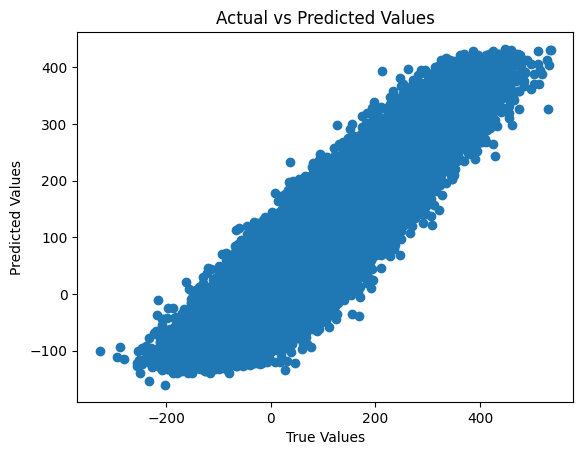

In [5]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

if __name__ == '__main__':
    # Load the pipeline
    with open('random_forest_pipeline.pkl', 'rb') as f:
        loaded_pipeline = pickle.load(f)

    # Read test data
    test_file = 'train_data2.csv'  # Specify your test data file
    df_test = pd.read_csv(test_file, index_col=0)

    # Ensure the columns match the training data
    X_test = df_test.drop(columns=['outcome'])
    y_true = df_test['outcome'].values

    # Predict on the test set
    y_pred = loaded_pipeline.predict(X_test)

    # Calculate the mean squared error
    mse = np.mean((y_true - y_pred) ** 2)
    print(f'Mean Squared Error: {mse}')

    # Plot actual vs predicted values
    plt.scatter(y_true, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()
